In [2]:
#
from google.colab import drive

drive.mount('./Drive')
#

Mounted at ./Drive


In [3]:
#
!git clone https://github.com/cloner174/UNetModel.git

Cloning into 'UNetModel'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 90 (delta 29), reused 40 (delta 14), pack-reused 31 (from 1)
Receiving objects: 100% (90/90), 77.78 MiB | 13.35 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [1]:
%cd UNetModel
#

/content/UNetModel


In [2]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

from datasets import FullyAnnotatedDataset, WeaklyAnnotatedDataset
from UNet import MultitaskAttentionUNet
from utils import visualize_predictions
from losses import dice_loss, CombinedLoss

In [3]:
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

capability = torch.cuda.get_device_capability(device)

print(f"Compute capability: {capability[0]}.{capability[1]}")

os.environ.setdefault('TORCH_CUDA_ARCH_LIST', f"{capability[0]}.{capability[1]}")

print(f'Using device: {device}')

Compute capability: 7.5
Using device: cuda


In [4]:
#
base_dir = '/content/Drive/MyDrive/LunaProject' #/main

In [5]:
X = np.load(base_dir + '/X.npy')
masks = np.load(base_dir + '/masks.npy')
boxes = np.load(base_dir + '/y_centroids.npy')
y_class = np.load(base_dir + '/y_class.npy')

In [6]:
X_weak = np.load(base_dir + '/images.npy')
y_train_weak = np.load(base_dir + '/labels.npy')

In [7]:
X_train, X_val, masks_train, masks_val, boxes_train, boxes_val, y_train, y_val = train_test_split(
        X , masks, boxes, y_class,
        test_size=0.2, random_state=42, shuffle=True
)

In [8]:
annotated_dataset = FullyAnnotatedDataset(X_train, masks_train, boxes_train, y_train, transform=None)

weak_dataset = WeaklyAnnotatedDataset(X_weak, y_train_weak, transform=None)

val_dataset = FullyAnnotatedDataset(X_val, masks_val, boxes_val, y_val, transform=None)

In [9]:
annotated_loader = DataLoader(annotated_dataset, batch_size=64, shuffle=True, num_workers=2)

weak_loader = DataLoader(weak_dataset, batch_size=64, shuffle=True, num_workers=2)

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

مدل معمولی

In [10]:
model = MultitaskAttentionUNet(input_channels=1, num_classes=1, bbox_size=4).to(device)

In [11]:
import torch
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

In [12]:
criterion_seg = CombinedLoss()
criterion_cls = nn.BCEWithLogitsLoss()
criterion_loc = nn.MSELoss()

In [13]:
#
optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.4, patience=4)
#

In [14]:
base_dir = './'
num_epochs = 20
best_val_loss = float('inf')

In [37]:
for epoch in range(1, num_epochs + 1):

    model.train()
    train_seg_loss = 0.0
    train_cls_loss = 0.0
    train_loc_loss = 0.0
    train_total = 0

    for batch in tqdm(annotated_loader, desc=f'Epoch {epoch}/{num_epochs} - Annotated-Training'):

        images, masks, labels, boxes = batch
        images = images.to(device)
        masks = masks.to(device)
        labels = labels.to(device).unsqueeze(1)
        boxes = boxes.to(device)

        optimizer.zero_grad()

        outputs_seg, outputs_cls, outputs_loc = model(images)


        loss_seg = criterion_seg(outputs_seg, masks.float())
        loss_cls = criterion_cls(outputs_cls, labels)
        loss_loc = criterion_loc(outputs_loc, boxes)

        loss = loss_seg + loss_cls + loss_loc

        loss.backward()
        optimizer.step()

        train_seg_loss += loss_seg.item() * images.size(0)
        train_cls_loss += loss_cls.item() * images.size(0)
        train_loc_loss += loss_loc.item() * images.size(0)
        train_total += images.size(0)

    avg_train_seg_loss = train_seg_loss / train_total
    avg_train_cls_loss = train_cls_loss / train_total
    avg_train_loc_loss = train_loc_loss / train_total
    avg_train_loss = avg_train_seg_loss + avg_train_cls_loss + avg_train_loc_loss

    model.eval()
    val_seg_loss = 0.0
    val_cls_loss = 0.0
    val_loc_loss = 0.0
    val_total = 0
    correct_cls = 0
    total_cls = 0

    with torch.no_grad():

        for batch in tqdm(val_loader, desc=f'Epoch {epoch}/{num_epochs} - Validation'):

            images, masks, labels, boxes = batch
            images = images.to(device)
            masks = masks.to(device)
            labels = labels.to(device).unsqueeze(1)
            boxes = boxes.to(device)

            outputs_seg, outputs_cls, outputs_loc = model(images)

            loss_seg = criterion_seg(outputs_seg, masks.float())
            loss_cls = criterion_cls(outputs_cls, labels)
            loss_loc = criterion_loc(outputs_loc, boxes)

            val_seg_loss += loss_seg.item() * images.size(0)
            val_cls_loss += loss_cls.item() * images.size(0)
            val_loc_loss += loss_loc.item() * images.size(0)
            val_total += images.size(0)

            preds_cls = (torch.sigmoid(outputs_cls) > 0.5).float()
            correct_cls += (preds_cls == labels).sum().item()
            total_cls += labels.size(0)

    avg_val_seg_loss = val_seg_loss / val_total
    avg_val_cls_loss = val_cls_loss / val_total
    avg_val_loc_loss = val_loc_loss / val_total
    avg_val_loss = avg_val_seg_loss + avg_val_cls_loss + avg_val_loc_loss
    val_accuracy = correct_cls / total_cls

    scheduler.step(avg_val_loss)

    print(f'Epoch [{epoch}/{num_epochs}] \n'
          f'Train Loss: {avg_train_loss:.4f} (Seg: {avg_train_seg_loss:.4f}, '
          f'Cls: {avg_train_cls_loss:.4f}, Loc: {avg_train_loc_loss:.4f}) \n'
          f'Val Loss: {avg_val_loss:.4f} (Seg: {avg_val_seg_loss:.4f}, '
          f'Cls: {avg_val_cls_loss:.4f}, Loc: {avg_val_loc_loss:.4f}) \n'
          f'Val Acc: {val_accuracy:.4f} \n')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(base_dir, 'UNet.pth'))
        print('Best model saved! \n')


Epoch 1/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.74it/s]


Epoch [1/20] 
Train Loss: 0.8759 (Seg: 0.8529, Cls: 0.0140, Loc: 0.0090) 
Val Loss: 0.8279 (Seg: 0.8072, Cls: 0.0151, Loc: 0.0056) 
Val Acc: 0.9946 

Best model saved! 



Epoch 2/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 10.96it/s]


Epoch [2/20] 
Train Loss: 0.7905 (Seg: 0.7727, Cls: 0.0101, Loc: 0.0078) 
Val Loss: 0.8429 (Seg: 0.8006, Cls: 0.0290, Loc: 0.0133) 
Val Acc: 0.9917 



Epoch 3/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.46it/s]


Epoch [3/20] 
Train Loss: 0.7519 (Seg: 0.7365, Cls: 0.0084, Loc: 0.0070) 
Val Loss: 0.8006 (Seg: 0.7545, Cls: 0.0342, Loc: 0.0119) 
Val Acc: 0.9880 

Best model saved! 



Epoch 4/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.61it/s]


Epoch [4/20] 
Train Loss: 0.7267 (Seg: 0.7110, Cls: 0.0088, Loc: 0.0069) 
Val Loss: 0.7614 (Seg: 0.7409, Cls: 0.0136, Loc: 0.0069) 
Val Acc: 0.9953 

Best model saved! 



Epoch 5/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.06it/s]


Epoch [5/20] 
Train Loss: 0.7144 (Seg: 0.6966, Cls: 0.0108, Loc: 0.0069) 
Val Loss: 0.7362 (Seg: 0.7181, Cls: 0.0127, Loc: 0.0054) 
Val Acc: 0.9956 

Best model saved! 



Epoch 6/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.34it/s]


Epoch [6/20] 
Train Loss: 0.6924 (Seg: 0.6803, Cls: 0.0059, Loc: 0.0062) 
Val Loss: 0.7094 (Seg: 0.6975, Cls: 0.0080, Loc: 0.0039) 
Val Acc: 0.9978 

Best model saved! 



Epoch 7/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.59it/s]


Epoch [7/20] 
Train Loss: 0.6752 (Seg: 0.6645, Cls: 0.0048, Loc: 0.0059) 
Val Loss: 0.6933 (Seg: 0.6792, Cls: 0.0107, Loc: 0.0035) 
Val Acc: 0.9958 

Best model saved! 



Epoch 8/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.49it/s]


Epoch [8/20] 
Train Loss: 0.6693 (Seg: 0.6565, Cls: 0.0070, Loc: 0.0059) 
Val Loss: 0.6814 (Seg: 0.6738, Cls: 0.0040, Loc: 0.0036) 
Val Acc: 0.9990 

Best model saved! 



Epoch 9/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.13it/s]


Epoch [9/20] 
Train Loss: 0.6678 (Seg: 0.6514, Cls: 0.0100, Loc: 0.0064) 
Val Loss: 0.6951 (Seg: 0.6723, Cls: 0.0175, Loc: 0.0053) 
Val Acc: 0.9929 



Epoch 10/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.37it/s]


Epoch [10/20] 
Train Loss: 0.6523 (Seg: 0.6431, Cls: 0.0035, Loc: 0.0056) 
Val Loss: 0.6670 (Seg: 0.6603, Cls: 0.0035, Loc: 0.0031) 
Val Acc: 0.9983 

Best model saved! 



Epoch 11/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.57it/s]


Epoch [11/20] 
Train Loss: 0.6385 (Seg: 0.6325, Cls: 0.0011, Loc: 0.0049) 
Val Loss: 0.6553 (Seg: 0.6493, Cls: 0.0020, Loc: 0.0040) 
Val Acc: 0.9995 

Best model saved! 



Epoch 12/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.09it/s]


Epoch [12/20] 
Train Loss: 0.6306 (Seg: 0.6257, Cls: 0.0002, Loc: 0.0047) 
Val Loss: 0.6561 (Seg: 0.6504, Cls: 0.0012, Loc: 0.0045) 
Val Acc: 0.9995 



Epoch 13/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.49it/s]


Epoch [13/20] 
Train Loss: 0.6279 (Seg: 0.6222, Cls: 0.0009, Loc: 0.0047) 
Val Loss: 0.6723 (Seg: 0.6492, Cls: 0.0193, Loc: 0.0039) 
Val Acc: 0.9934 



Epoch 14/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.48it/s]


Epoch [14/20] 
Train Loss: 0.6586 (Seg: 0.6347, Cls: 0.0168, Loc: 0.0071) 
Val Loss: 0.7478 (Seg: 0.6931, Cls: 0.0407, Loc: 0.0141) 
Val Acc: 0.9882 



Epoch 15/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.01it/s]


Epoch [15/20] 
Train Loss: 0.6402 (Seg: 0.6264, Cls: 0.0079, Loc: 0.0059) 
Val Loss: 0.7076 (Seg: 0.6692, Cls: 0.0268, Loc: 0.0116) 
Val Acc: 0.9904 



Epoch 16/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.62it/s]


Epoch [16/20] 
Train Loss: 0.6328 (Seg: 0.6223, Cls: 0.0051, Loc: 0.0054) 
Val Loss: 0.6566 (Seg: 0.6486, Cls: 0.0039, Loc: 0.0041) 
Val Acc: 0.9985 



Epoch 17/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.20it/s]


Epoch [17/20] 
Train Loss: 0.6137 (Seg: 0.6093, Cls: 0.0001, Loc: 0.0043) 
Val Loss: 0.6349 (Seg: 0.6300, Cls: 0.0029, Loc: 0.0020) 
Val Acc: 0.9985 

Best model saved! 



Epoch 18/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.35it/s]


Epoch [18/20] 
Train Loss: 0.6086 (Seg: 0.6046, Cls: 0.0001, Loc: 0.0040) 
Val Loss: 0.6333 (Seg: 0.6274, Cls: 0.0040, Loc: 0.0019) 
Val Acc: 0.9980 

Best model saved! 



Epoch 19/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.55it/s]


Epoch [19/20] 
Train Loss: 0.6072 (Seg: 0.6031, Cls: 0.0001, Loc: 0.0040) 
Val Loss: 0.6299 (Seg: 0.6264, Cls: 0.0016, Loc: 0.0019) 
Val Acc: 0.9993 

Best model saved! 



Epoch 20/20 - Validation: 100%|██████████| 64/64 [00:05<00:00, 11.15it/s]


Epoch [20/20] 
Train Loss: 0.6059 (Seg: 0.6020, Cls: 0.0001, Loc: 0.0039) 
Val Loss: 0.6264 (Seg: 0.6232, Cls: 0.0015, Loc: 0.0016) 
Val Acc: 0.9995 

Best model saved! 



In [ ]:
#train_model(model, annotated_loader, weak_loader, val_loader, device, num_epochs=2, patience=10, base_dir='./')

In [15]:
model.load_state_dict(torch.load(os.path.join('./', 'UNet.pth'), weights_only=True))
model.to(device)

MultitaskAttentionUNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

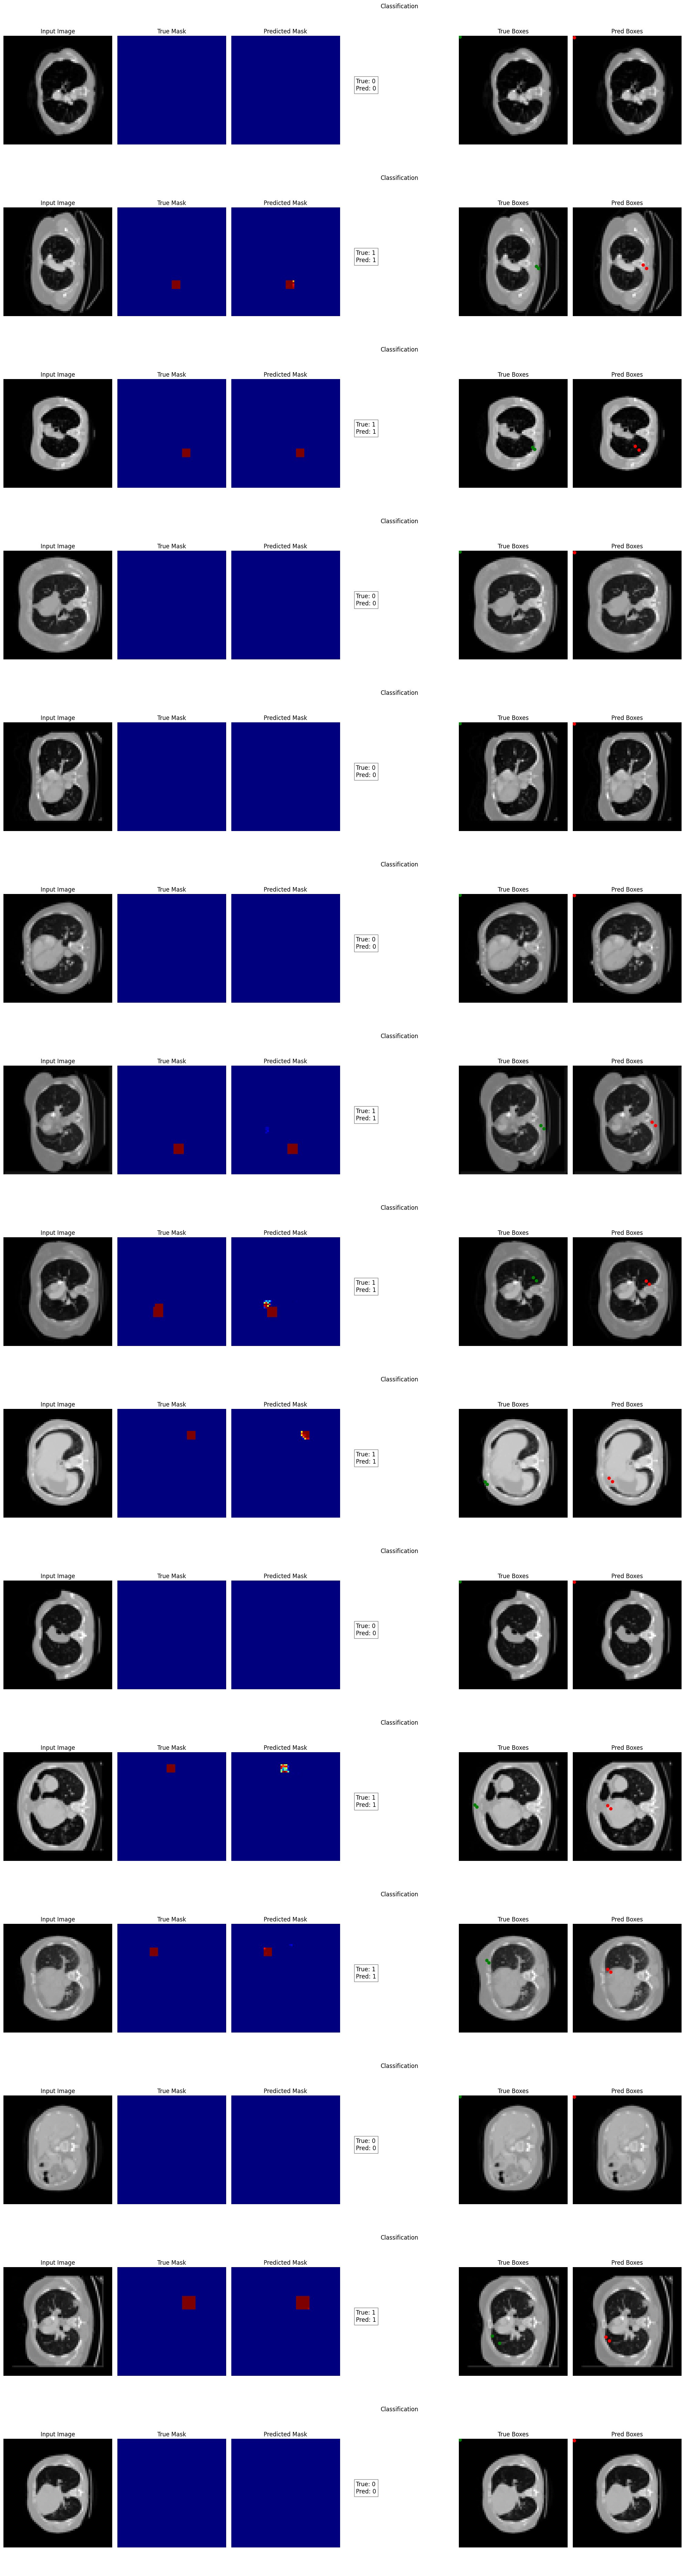

In [42]:
visualize_predictions(model, val_loader, device, num_samples=15, num_classes=1)

In [47]:
import matplotlib.pyplot as plt
import torch


def visualize_predictions(model, dataloader, device, num_samples=5, num_classes=1):

    model.eval()
    images_shown = 0
    plt.figure(figsize=(20, num_samples * 5))

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 4:
                images, masks, labels, boxes = batch
                is_annotated = True
            else:
                images, labels = batch
                is_annotated = False

            images = images.to(device)

            if is_annotated:
                masks = masks.to(device)
                boxes = boxes.to(device)
                labels = labels.to(device)

            outputs_seg, outputs_cls, outputs_loc = model(images)

            preds_seg = torch.argmax(outputs_seg, dim=1)
            preds_cls = (torch.sigmoid(outputs_cls) > 0.5).float()
            preds_loc = outputs_loc * 64.0

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    break

                img = images[i].cpu().squeeze().numpy()
                if is_annotated:
                    true_mask = masks[i].cpu().numpy()
                    true_box = boxes[i].cpu().numpy() * 64.0
                    true_label = labels[i].item()
                else:
                    true_mask = None
                    true_box = None
                    true_label = 1


                pred_cls = preds_cls[i].item()

                if int(pred_cls) == 1 :
                    pred = torch.sigmoid(outputs_seg[i])
                    pred_mask = pred.squeeze().cpu().numpy()
                else:
                    pred_mask = preds_seg[i].cpu().numpy()

                pred_box = preds_loc[i].cpu().numpy()


                plt.subplot(num_samples, 6, images_shown * 6 + 1)
                plt.imshow(img, cmap='gray')
                plt.title('Input Image')
                plt.axis('off')

                if is_annotated:
                    plt.subplot(num_samples, 6, images_shown * 6 + 2)
                    plt.imshow(true_mask, cmap='jet')
                    plt.title('True Mask')
                    plt.axis('off')
                else:
                    plt.subplot(num_samples, 6, images_shown * 6 + 2)
                    plt.axis('off')

                plt.subplot(num_samples, 6, images_shown * 6 + 3)
                plt.imshow(pred_mask, cmap='jet')
                plt.title('Predicted Mask')
                plt.axis('off')

                plt.subplot(num_samples, 6, images_shown * 6 + 4)
                if is_annotated:
                    plt.text(0.1, 0.5, f'True: {int(true_label)}\nPred: {int(pred_cls)}',
                             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
                else:
                    plt.text(0.1, 0.5, f'Pred: {int(pred_cls)}',
                             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

                plt.title('Classification')
                plt.axis('off')

                if is_annotated:
                    plt.subplot(num_samples, 6, images_shown * 6 + 5)
                    plt.imshow(img, cmap='gray')
                    plt.title('True Boxes')
                    plt.axis('off')
                    for b in range(0, len(true_box), 2):
                        plt.plot(true_box[b], true_box[b+1], 'go-')
                else:
                    plt.subplot(num_samples, 6, images_shown * 6 + 5)
                    plt.axis('off')

                plt.subplot(num_samples, 6, images_shown * 6 + 6)
                plt.imshow(img, cmap='gray')
                plt.title('Pred Boxes')
                plt.axis('off')
                for b in range(0, len(pred_box), 2):
                    plt.plot(pred_box[b], pred_box[b+1], 'ro-')

                images_shown += 1

            if images_shown >= num_samples:
                break

    plt.tight_layout()
    plt.show()
#cloner174

In [ ]:
#
!cp ./UNet.pth {base_dir}
#

استفاده از رزنت

**به هیچ وجه توضیه نمیشه چون اولا برای داده های سه بعدی سه کاناله مناسبه هم اینکه اطلاعات حیاتی از تصویر رو توی مراحل کارش از دست میدیم**

فقط جهت اطلاع -- نتایج غیرقابل قبول

In [ ]:
#from UNet import MultitaskAttentionUNet_Pretrained

In [ ]:
#from UNet import MultitaskAttentionUNet_Pretrained
#model = MultitaskAttentionUNet_Pretrained(input_channels=1, num_classes=1, bbox_size=4).to(device)

In [ ]:
#train_model(model, annotated_loader, weak_loader, val_loader, device, num_epochs=2, patience=10, base_dir='./')

In [81]:
from metrics import calculate_segmentation_metrics, calculate_classification_metrics, calculate_localization_metrics

In [ ]:
preds_cls_v = (torch.sigmoid(outputs_cls_v.squeeze()) > 0.5).float()

In [ ]:
#outputs_seg, outputs_cls, outputs_loc = model(images)

            loss_seg = criterion_seg(outputs_seg, masks.float())
            loss_cls = criterion_cls(outputs_cls, labels)
            loss_loc = criterion_loc(outputs_loc, boxes)

            val_seg_loss += loss_seg.item() * images.size(0)
            val_cls_loss += loss_cls.item() * images.size(0)
            val_loc_loss += loss_loc.item() * images.size(0)
            val_total += images.size(0)

            preds_cls = (torch.sigmoid(outputs_cls) > 0.5).float()
            correct_cls += (preds_cls == labels).sum().item()
            total_cls += labels.size(0)

In [99]:
preds_cls = (torch.sigmoid(outputs_cls) > 0.5).float()
actual_cls = (torch.sigmoid(labels) > 0.5).float()

In [100]:
preds_cls.sum().tolist(), actual_cls.sum().tolist(),

(19.0, 19.0)

In [102]:
#
dice_v, iou_v = calculate_segmentation_metrics(outputs_seg, masks)

prec_v, rec_v, f1_v, roc_auc_v = calculate_classification_metrics(outputs_cls, labels)

loc_metr = calculate_localization_metrics(outputs_loc, boxes)
#
print(f'Dice: {dice_v}, IoU: {iou_v}')
print(f'ROC_AUC: {roc_auc_v}, F1Score: {f1_v}')
print(f'Prec: {prec_v}, Rec: {rec_v}')
print(f'Loc_Metr: {loc_metr}')

Dice: 1.8696418034665778, IoU: 0.020293439174458125
ROC_AUC: 1.0, F1Score: 1.0
Prec: 1.0, Rec: 1.0
Loc_Metr: 0.01872173137962818


In [ ]:
#model.load_state_dict(torch.load(os.path.join('./', 'best_model.pth'), weights_only=True))
#model.to(device)

MultitaskAttentionUNet(
  (enc1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
#val_dataset_for_visual = FullyAnnotatedDataset(X_val, masks_val, boxes_val, y_val, transform=None, unsqueeze_mask=False)

#val_loader_for_visual = DataLoader(val_dataset_for_visual, batch_size=64, shuffle=False, num_workers=4)

In [ ]:
#visualize_predictions(model, val_loader_for_visual, device, num_samples=15, num_classes=1)

In [43]:
outputs_seg.size()

torch.Size([47, 1, 64, 64])

In [50]:
images.squeeze().size()

torch.Size([47, 64, 64])

In [52]:
images.squeeze().cpu().numpy().shape

(47, 64, 64)

In [51]:
outputs_seg.squeeze().cpu().numpy().shape

(47, 64, 64)

In [53]:
masks.squeeze().cpu().numpy().shape

(47, 64, 64)

In [54]:
import matplotlib.pyplot as plt

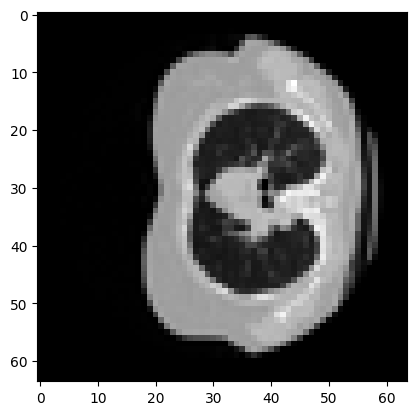

In [63]:
plt.imshow(images.squeeze().cpu().numpy()[30] , cmap= 'gray')

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_circles_on_masked_regions(images, masks):
    if len(images) != len(masks):
        raise ValueError("The number of images and masks must be the same")
    for i, (image, mask) in enumerate(zip(images, masks)):
        binary_mask = mask.astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            cv2.circle(image, center, radius, (0, 255, 0), 2)
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Creating some example images and masks
    image1 = np.zeros((200, 200, 3), dtype=np.uint8)
    image2 = np.zeros((200, 200, 3), dtype=np.uint8)
    mask1 = np.zeros((200, 200), dtype=np.uint8)
    mask2 = np.zeros((200, 200), dtype=np.uint8)

    # Draw some example regions in masks
    cv2.circle(mask1, (100, 100), 40, 255, -1)
    cv2.rectangle(mask2, (50, 50), (150, 150), 255, -1)

    images = [image1, image2]
    masks = [mask1, mask2]

    # Call the function to draw circles on masked regions
    draw_circles_on_masked_regions(images, masks)


In [59]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_circles_on_masked_regions(images, masks):
    if len(images) != len(masks):
        raise ValueError("The number of images and masks must be the same")
    for i, (image, mask) in enumerate(zip(images, masks)):
        binary_mask = mask.astype(np.uint8)
        contours, _ = cv2.findContours(masks, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            cv2.circle(image, center, radius, (0, 255, 0), 2)
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

In [ ]:
masks.squeeze().cpu().numpy()[5].any()

In [76]:

binary_mask = masks.squeeze().cpu().numpy()[5].astype(np.uint8)


contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
plt.subplot(1, len(images), i + 1)

In [79]:
contours

(array([[[23, 19]],
 
        [[23, 24]],
 
        [[27, 24]],
 
        [[27, 19]]], dtype=int32),)

In [80]:
cv2.minEnclosingCircle(contour)

((25.0, 21.5), 3.201662063598633)

In [78]:
for contour in contours:
  (x, y), radius = cv2.minEnclosingCircle(contour)
  center = (int(x), int(y))
  radius = int(radius)
  cv2.circle(images.squeeze().cpu().numpy()[5], center, radius, (0, 255, 0), 2)

plt.show()

True

In [ ]:
for contour in contours:


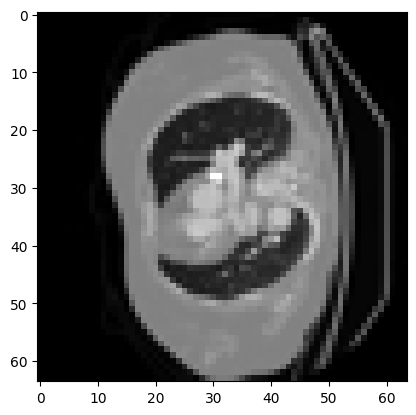

In [77]:
plt.imshow(images.squeeze().cpu().numpy()[5] , cmap= 'gray')

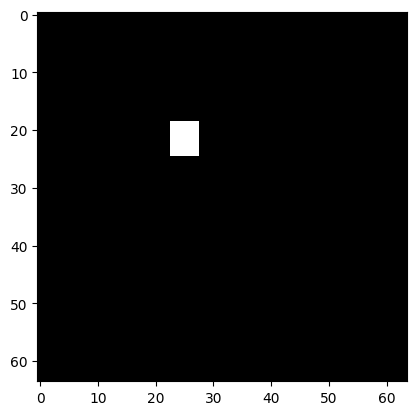

In [71]:
plt.imshow(masks.squeeze().cpu().numpy()[5] , cmap= 'gray')

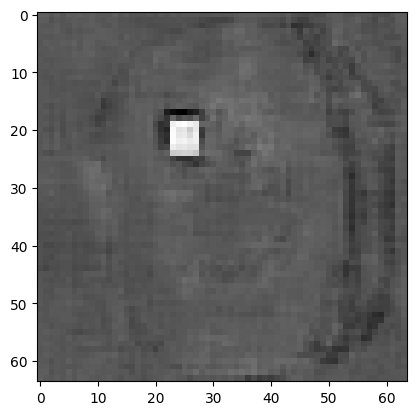

In [72]:
plt.imshow(outputs_seg.squeeze().cpu().numpy()[5] , cmap= 'gray')

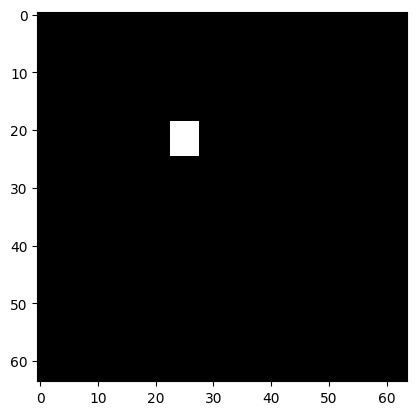

In [75]:
pred = torch.sigmoid(outputs_seg[5])
plt.imshow(pred.squeeze().cpu().numpy() , cmap= 'gray')

In [74]:
pred.squeeze().cpu().numpy()

array([[1.3735347e-05, 1.3557784e-05, 2.6948705e-06, ..., 1.7906856e-06,
        7.6371507e-06, 6.5317727e-06],
       [6.4447263e-06, 6.0329085e-06, 1.3063016e-06, ..., 6.4158280e-07,
        5.4636726e-06, 9.5258938e-06],
       [3.6654499e-06, 2.8926736e-06, 2.6832688e-06, ..., 1.4332609e-06,
        4.8195116e-06, 6.7879264e-06],
       ...,
       [4.3065684e-06, 5.9934605e-06, 2.1520316e-06, ..., 3.3523154e-06,
        9.3188805e-07, 1.9102256e-06],
       [7.7111335e-06, 7.2392809e-06, 1.2869217e-06, ..., 3.0796782e-06,
        3.1255188e-06, 4.8317252e-06],
       [1.0388407e-05, 4.7727617e-06, 2.6127507e-06, ..., 2.0713442e-06,
        2.4789597e-06, 2.5304553e-06]], dtype=float32)